# 05 - Modelo con Feature Engineering y Gradient Boosting


Importación de librerías para Feature Engineering y XGBoost

In [1]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Modelos de Machine Learning - Enfoque en Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# XGBoost (si está disponible, sino usaremos GradientBoostingClassifier)
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
    print("XGBoost disponible")
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost no disponible, usando GradientBoostingClassifier")

# Configuración de visualizaciones
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")
pd.set_option('display.max_columns', None)

XGBoost disponible


## 2. Carga de datos

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 1.94GB/s]


In [3]:
!unzip udea*.zip > /dev/null

In [4]:
!wc *.csv

   296787    296787   4716673 submission_example.csv
   296787   4565553  59185250 test.csv
   692501  10666231 143732449 train.csv
   210134    675821  60817408 train_processed.csv
  1496209  16204392 268451780 total


In [5]:
# Cargar datos preprocesados del notebook 02
df_train = pd.read_csv('train_processed.csv')
df_test = pd.read_csv('test.csv')

print(f"Datos cargados - Entrenamiento: {df_train.shape}, Prueba: {df_test.shape}")
print(f"Primeras filas del dataset:")
display(df_train.head(3))

Datos cargados - Entrenamiento: (692500, 54), Prueba: (296786, 20)
Primeras filas del dataset:


,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_EDUCACIONPADRE,FAMI_TIENEINTERNET.1,FAMI_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,coef_1,coef_2,coef_3,coef_4,ESTU_PRGM_ACADEMICO_ORIGINAL,prgm_administracion de empresas,prgm_administracion en salud ocupacional,prgm_administracion financiera,prgm_arquitectura,prgm_comunicacion social,prgm_contaduria publica,prgm_derecho,prgm_economia,prgm_enfermeria,prgm_ingenieria ambiental,prgm_ingenieria civil,prgm_ingenieria de sistemas,prgm_ingenieria electronica,prgm_ingenieria industrial,prgm_ingenieria mecanica,prgm_licenciatura en pedagogia infantil,prgm_medicina,prgm_negocios internacionales,prgm_otros,prgm_psicologia,prgm_trabajo social,FAMI_TIENEINTERNET_No,FAMI_TIENEINTERNET_Si,FAMI_TIENEINTERNET_no info,ESTU_PAGOMATRICULAPROPIO_No,ESTU_PAGOMATRICULAPROPIO_Si,ESTU_PAGOMATRICULAPROPIO_no info,FAMI_TIENELAVADORA_No,FAMI_TIENELAVADORA_Si,FAMI_TIENELAVADORA_no info,FAMI_TIENEAUTOMOVIL_No,FAMI_TIENEAUTOMOVIL_Si,FAMI_TIENEAUTOMOVIL_no info,ESTU_PRIVADO_LIBERTAD_N,ESTU_PRIVADO_LIBERTAD_S,FAMI_TIENECOMPUTADOR_No,FAMI_TIENECOMPUTADOR_Si,FAMI_TIENECOMPUTADOR_no info
0,904256,20212,enfermeria,BOGOTÁ,7.0,2.0,4.0,8.0,Si,12.0,3.0,0.322,0.208,0.310,0.267,enfermeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True,False,True,False,False,False,True,False,False,True,False,True,False,False,True,False
1,645256,20212,derecho,ATLANTICO,5.0,1.0,4.0,9.0,No,8.0,1.0,0.311,0.215,0.292,0.264,derecho,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,False,True,False,False,False,True,False,True,False,False,True,False,False,True,False
2,308367,20203,otros,BOGOTÁ,5.0,5.0,4.0,7.0,Si,7.0,1.0,0.297,0.214,0.305,0.264,mercadeo y publicidad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,True,False,True,False,False,False,True,False,True,False,False,True,False,True,False,False


## Preparación inicial de datos

In [6]:
# Separar características y variable objetivo
columns_to_drop = ['ESTU_CONSECUTIVO', 'ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_ACADEMICO_ORIGINAL']
columns_to_drop = [col for col in columns_to_drop if col in df_train.columns]

X_base = df_train.drop(columns=columns_to_drop + ['RENDIMIENTO_GLOBAL'])
y = df_train['RENDIMIENTO_GLOBAL']

print(f"Características base: {X_base.shape}, Variable objetivo: {y.shape}")

# Mapeo de etiquetas
label_mapping = {0: 'no info', 1: 'bajo', 2: 'medio-bajo', 3: 'medio-alto', 4: 'alto'}

print(f"Distribución de clases:")
class_dist = y.value_counts().sort_index()
for clase, count in class_dist.items():
    if clase in label_mapping:
        percentage = (count / len(y)) * 100
        print(f"  - {label_mapping[clase]}: {count:,} ({percentage:.1f}%)")

Características base: (692500, 51), Variable objetivo: (692500,)
Distribución de clases:
  - bajo: 172,987 (25.0%)
  - medio-bajo: 172,275 (24.9%)
  - medio-alto: 171,619 (24.8%)
  - alto: 175,619 (25.4%)


## Feature Engineering - Creación de nuevas características

Creamos características nuevas que podrían ser útiles para predecir el rendimiento académico.

In [7]:
# Crear copia para feature engineering
X_engineered = X_base.copy()

print("Creando nuevas características...")

# 1. Índice socioeconómico combinado
if all(col in X_engineered.columns for col in ['FAMI_ESTRATOVIVIENDA', 'ESTU_VALORMATRICULAUNIVERSIDAD']):
    X_engineered['INDICE_SOCIOECONOMICO'] = (
        X_engineered['FAMI_ESTRATOVIVIENDA'] +
        X_engineered['ESTU_VALORMATRICULAUNIVERSIDAD']
    ) / 2
    print("  - Índice socioeconómico creado")

# 2. Recursos tecnológicos del hogar
tech_columns = ['FAMI_TIENEINTERNET', 'FAMI_TIENECOMPUTADOR']
available_tech = [col for col in tech_columns if col in X_engineered.columns]
if available_tech:
    X_engineered['RECURSOS_TECNOLOGICOS'] = X_engineered[available_tech].sum(axis=1)
    print(f"  - Recursos tecnológicos creados ({len(available_tech)} variables)")

# 3. Recursos físicos del hogar
physical_columns = ['FAMI_TIENELAVADORA', 'FAMI_TIENEAUTOMOVIL']
available_physical = [col for col in physical_columns if col in X_engineered.columns]
if available_physical:
    X_engineered['RECURSOS_FISICOS'] = X_engineered[available_physical].sum(axis=1)
    print(f"  - Recursos físicos creados ({len(available_physical)} variables)")

# 4. Nivel educativo familiar
edu_columns = ['FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE']
available_edu = [col for col in edu_columns if col in X_engineered.columns]
if available_edu:
    X_engineered['EDUCACION_FAMILIAR_MAX'] = X_engineered[available_edu].max(axis=1)
    X_engineered['EDUCACION_FAMILIAR_PROMEDIO'] = X_engineered[available_edu].mean(axis=1)
    print(f"  - Educación familiar creada ({len(available_edu)} variables)")

# 5. Indicador de trabajo estudiantil
if 'ESTU_HORASSEMANATRABAJA' in X_engineered.columns:
    X_engineered['ESTUDIANTE_TRABAJA'] = (X_engineered['ESTU_HORASSEMANATRABAJA'] > 0).astype(int)
    X_engineered['TRABAJO_INTENSIVO'] = (X_engineered['ESTU_HORASSEMANATRABAJA'] > 20).astype(int)
    print("  - Indicadores de trabajo estudiantil creados")

# 6. Indicador de programa académico (si hay columnas de programas)
program_columns = [col for col in X_engineered.columns if col.startswith("('") and 'ADMINISTRACION' in col or 'INGENIERIA' in col or 'MEDICINA' in col]
if program_columns:
    # Crear indicador de programa "prestigioso" (ejemplo simple)
    prestigious_programs = [col for col in program_columns if any(keyword in col for keyword in ['INGENIERIA', 'MEDICINA', 'DERECHO'])]
    if prestigious_programs:
        X_engineered['PROGRAMA_PRESTIGIOSO'] = X_engineered[prestigious_programs].sum(axis=1)
        print(f"  - Indicador de programa prestigioso creado")

print(f"Características después de Feature Engineering: {X_engineered.shape}")
print(f"Nuevas características creadas: {X_engineered.shape[1] - X_base.shape[1]}")

# Mostrar las nuevas características
new_features = [col for col in X_engineered.columns if col not in X_base.columns]
print(f"Nuevas características:")
for feature in new_features:
    print(f"  - {feature}")

Creando nuevas características...
  - Índice socioeconómico creado
  - Educación familiar creada (2 variables)
  - Indicadores de trabajo estudiantil creados
Características después de Feature Engineering: (692500, 56)
Nuevas características creadas: 5
Nuevas características:
  - INDICE_SOCIOECONOMICO
  - EDUCACION_FAMILIAR_MAX
  - EDUCACION_FAMILIAR_PROMEDIO
  - ESTUDIANTE_TRABAJA
  - TRABAJO_INTENSIVO


## Análisis exploratorio de las nuevas características

Correlación de nuevas características con RENDIMIENTO_GLOBAL:

 Correlaciones (ordenadas por valor absoluto):
  📈 EDUCACION_FAMILIAR_PROMEDIO: 0.2739
  📈 INDICE_SOCIOECONOMICO: 0.2637
  📈 EDUCACION_FAMILIAR_MAX: 0.2588
  📈 ESTUDIANTE_TRABAJA: 0.0210
  📉 TRABAJO_INTENSIVO: nan


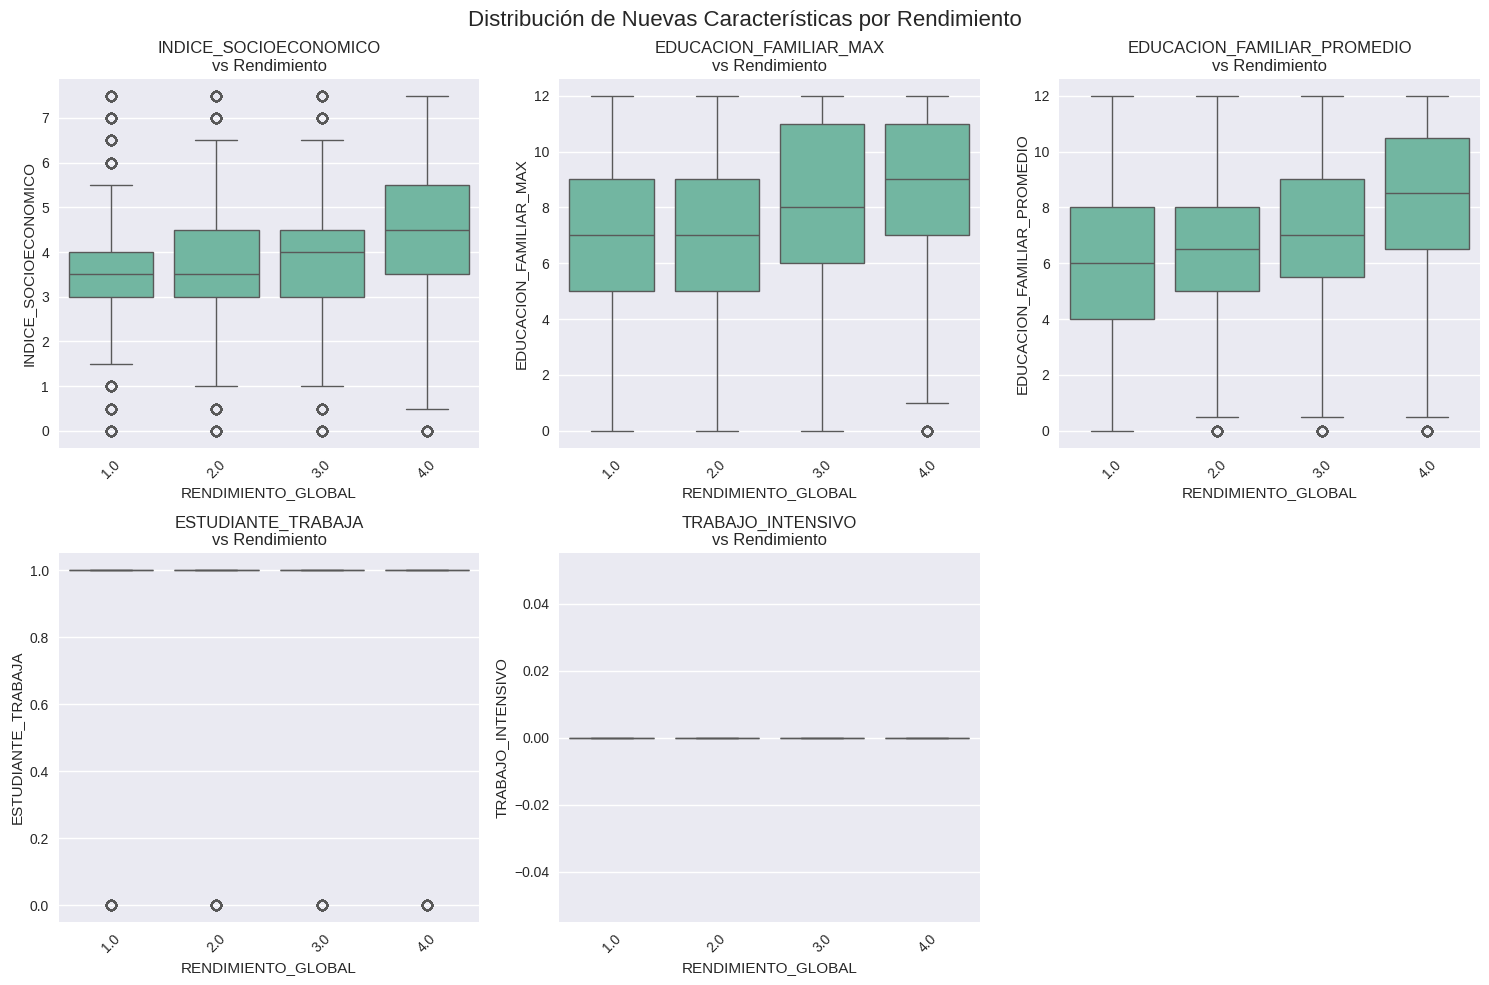

In [10]:
# Analizar correlación de nuevas características con la variable objetivo
if new_features:
    print("Correlación de nuevas características con RENDIMIENTO_GLOBAL:")

    # Crear DataFrame con nuevas características y target
    analysis_df = X_engineered[new_features].copy()
    analysis_df['RENDIMIENTO_GLOBAL'] = y

    # Calcular correlaciones
    correlations = analysis_df.corr()['RENDIMIENTO_GLOBAL'].drop('RENDIMIENTO_GLOBAL').sort_values(key=abs, ascending=False)

    print("\n Correlaciones (ordenadas por valor absoluto):")
    for feature, corr in correlations.items():
        direction = "📈" if corr > 0 else "📉"
        print(f"  {direction} {feature}: {corr:.4f}")

    # Visualización de correlaciones
    if len(new_features) <= 6:  # Solo si no son demasiadas
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()

        for i, feature in enumerate(new_features[:6]):
            if i < len(axes):
                # Box plot de la característica por clase de rendimiento
                sns.boxplot(data=analysis_df, x='RENDIMIENTO_GLOBAL', y=feature, ax=axes[i])
                axes[i].set_title(f'{feature}\nvs Rendimiento')
                axes[i].tick_params(axis='x', rotation=45)

        # Ocultar axes no usados
        for i in range(len(new_features), len(axes)):
            axes[i].set_visible(False)

        plt.suptitle('Distribución de Nuevas Características por Rendimiento', fontsize=16)
        plt.tight_layout()
        plt.show()
else:
    print(" No se crearon nuevas características para analizar")

## División de datos y preprocesamiento simple

In [12]:
# Usar las características con feature engineering
X = X_engineered.copy()

# Filtrar solo columnas numéricas para evitar errores con StandardScaler
numeric_columns = X.select_dtypes(include=[np.number]).columns
X_numeric = X[numeric_columns]

print(f"Columnas totales: {X.shape[1]}, Columnas numéricas: {X_numeric.shape[1]}")

# División estratificada de datos
X_temp, X_test, y_temp, y_test = train_test_split(
    X_numeric, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"División de datos:")
print(f"  - Entrenamiento: {X_train.shape[0]:,} muestras")
print(f"  - Validación: {X_val.shape[0]:,} muestras")
print(f"  - Prueba: {X_test.shape[0]:,} muestras")

# Preprocesamiento simple: solo StandardScaler (sin PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Preprocesamiento completado - Características numéricas: {X_train_scaled.shape[1]}")

# Actualizar X para usar solo las columnas numéricas
X = X_numeric.copy()

Columnas totales: 56, Columnas numéricas: 37
División de datos:
  - Entrenamiento: 415,500 muestras
  - Validación: 138,500 muestras
  - Prueba: 138,500 muestras
Preprocesamiento completado - Características numéricas: 37


## Modelos de Gradient Boosting y comparación

In [14]:
# Mapear las etiquetas para que empiecen desde 0 (requerido por XGBoost)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Crear versiones mapeadas de las etiquetas
y_train_mapped = label_encoder.fit_transform(y_train)
y_val_mapped = label_encoder.transform(y_val)

# Mostrar el mapeo
print("Mapeo de etiquetas para XGBoost:")
for original, mapped in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"  {original} -> {mapped}")

# Definir modelos a comparar
models = {}

# Gradient Boosting de sklearn (puede usar las etiquetas originales)
models['Gradient Boosting'] = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# XGBoost si está disponible (usar etiquetas mapeadas)
if XGBOOST_AVAILABLE:
    models['XGBoost'] = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        eval_metric='mlogloss'
    )

# Modelos de comparación
models['Random Forest'] = RandomForestClassifier(n_estimators=100, random_state=42)
models['Logistic Regression'] = LogisticRegression(random_state=42, max_iter=1000)

print(f"\nEvaluando {len(models)} modelos con validación cruzada...")

Mapeo de etiquetas para XGBoost:
  1.0 -> 0
  2.0 -> 1
  3.0 -> 2
  4.0 -> 3

Evaluando 4 modelos con validación cruzada...


Gradient Boosting: 0.4016 (±0.0015)
XGBoost: 0.3989 (±0.0011)
Random Forest: 0.3816 (±0.0004)
Logistic Regression: 0.3761 (±0.0004)

Ranking de modelos:


,Model,Mean_Accuracy,Std_Accuracy
0,Gradient Boosting,0.401596,0.001548
1,XGBoost,0.398927,0.001111
2,Random Forest,0.381576,0.000354
3,Logistic Regression,0.376070,0.000429


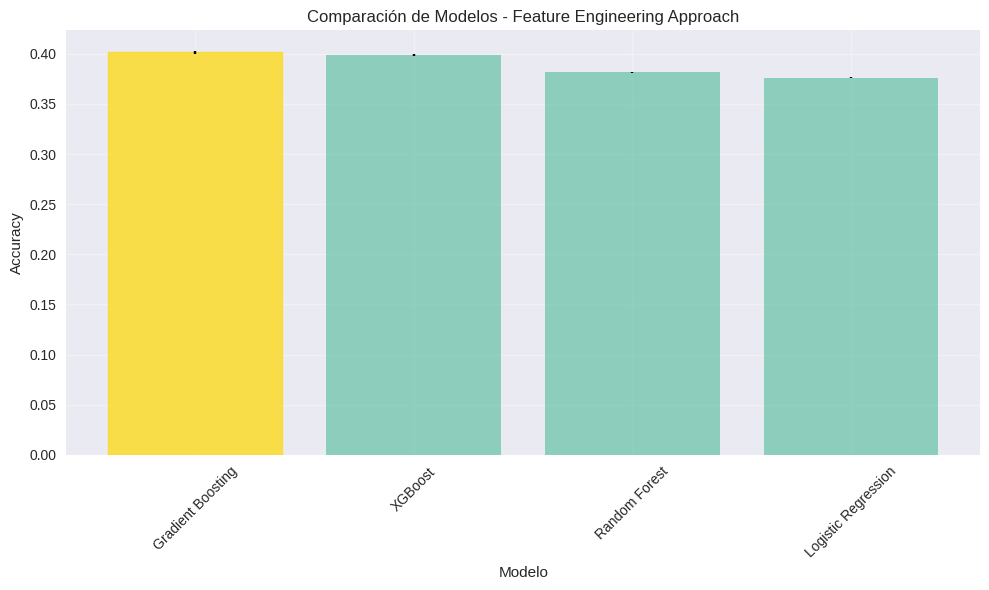

Mejor modelo: Gradient Boosting


In [15]:
# Configurar validación cruzada
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
results = {}

for name, model in models.items():
    # Usar etiquetas mapeadas para XGBoost, originales para otros
    if name == 'XGBoost':
        cv_scores = cross_val_score(model, X_train_scaled, y_train_mapped, cv=cv, scoring='accuracy')
    else:
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')

    results[name] = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std(),
        'scores': cv_scores
    }

    print(f"{name}: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Crear DataFrame para visualización
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Mean_Accuracy': [results[name]['mean'] for name in results.keys()],
    'Std_Accuracy': [results[name]['std'] for name in results.keys()]
}).sort_values('Mean_Accuracy', ascending=False)

print(f"\nRanking de modelos:")
display(results_df)

# Visualización
plt.figure(figsize=(10, 6))
bars = plt.bar(results_df['Model'], results_df['Mean_Accuracy'],
        yerr=results_df['Std_Accuracy'], capsize=5, alpha=0.7)
plt.title('Comparación de Modelos - Feature Engineering Approach')
plt.xlabel('Modelo')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Colorear la mejor barra
bars[0].set_color('gold')

plt.tight_layout()
plt.show()

best_model_name = results_df.iloc[0]['Model']
print(f"Mejor modelo: {best_model_name}")

## Entrenamiento y evaluación

Accuracy en validación: 0.4008
Reporte de clasificación (Validación):
              precision    recall  f1-score   support

        bajo       0.41      0.52      0.46     34597
  medio-bajo       0.33      0.26      0.29     34455
  medio-alto       0.30      0.22      0.25     34324
        alto       0.49      0.60      0.54     35124

    accuracy                           0.40    138500
   macro avg       0.38      0.40      0.39    138500
weighted avg       0.38      0.40      0.39    138500



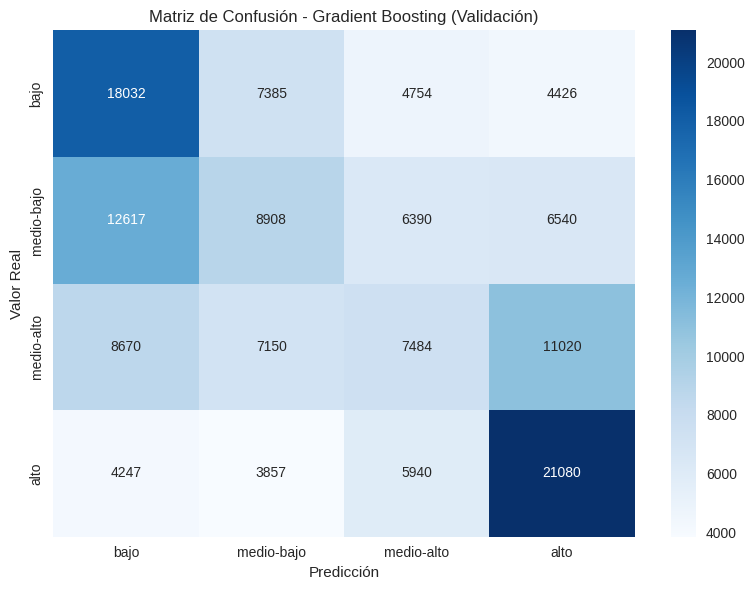

In [16]:
# Entrenar el mejor modelo
best_model = models[best_model_name]
best_model.fit(X_train_scaled, y_train)

# Predicciones en validación
y_val_pred = best_model.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"Accuracy en validación: {val_accuracy:.4f}")

# Reporte detallado
print(f"Reporte de clasificación:")
target_names = [label_mapping[i] for i in sorted(label_mapping.keys()) if i in y_val.unique()]
print(classification_report(y_val, y_val_pred, target_names=target_names))

# Matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[label_mapping[i] for i in sorted(set(y_val))],
            yticklabels=[label_mapping[i] for i in sorted(set(y_val))])
plt.title(f'Matriz de Confusión - {best_model_name} (Validación)')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.tight_layout()
plt.show()

## Análisis de importancia de características

Analizando importancia de características para Gradient Boosting...
Top 15 características más importantes:


,feature,importance
2,ESTU_VALORMATRICULAUNIVERSIDAD,0.440219
34,EDUCACION_FAMILIAR_PROMEDIO,0.097961
32,INDICE_SOCIOECONOMICO,0.061858
6,FAMI_EDUCACIONMADRE,0.052199
3,ESTU_HORASSEMANATRABAJA,0.038905
33,EDUCACION_FAMILIAR_MAX,0.036418
4,FAMI_ESTRATOVIVIENDA,0.034467
1,PERIODO,0.030180
7,coef_1,0.028392
26,prgm_licenciatura en pedagogia infantil,0.027886


Nuevas características en el Top 15:
  #35: EDUCACION_FAMILIAR_PROMEDIO (importancia: 0.0980)
  #33: INDICE_SOCIOECONOMICO (importancia: 0.0619)
  #34: EDUCACION_FAMILIAR_MAX (importancia: 0.0364)


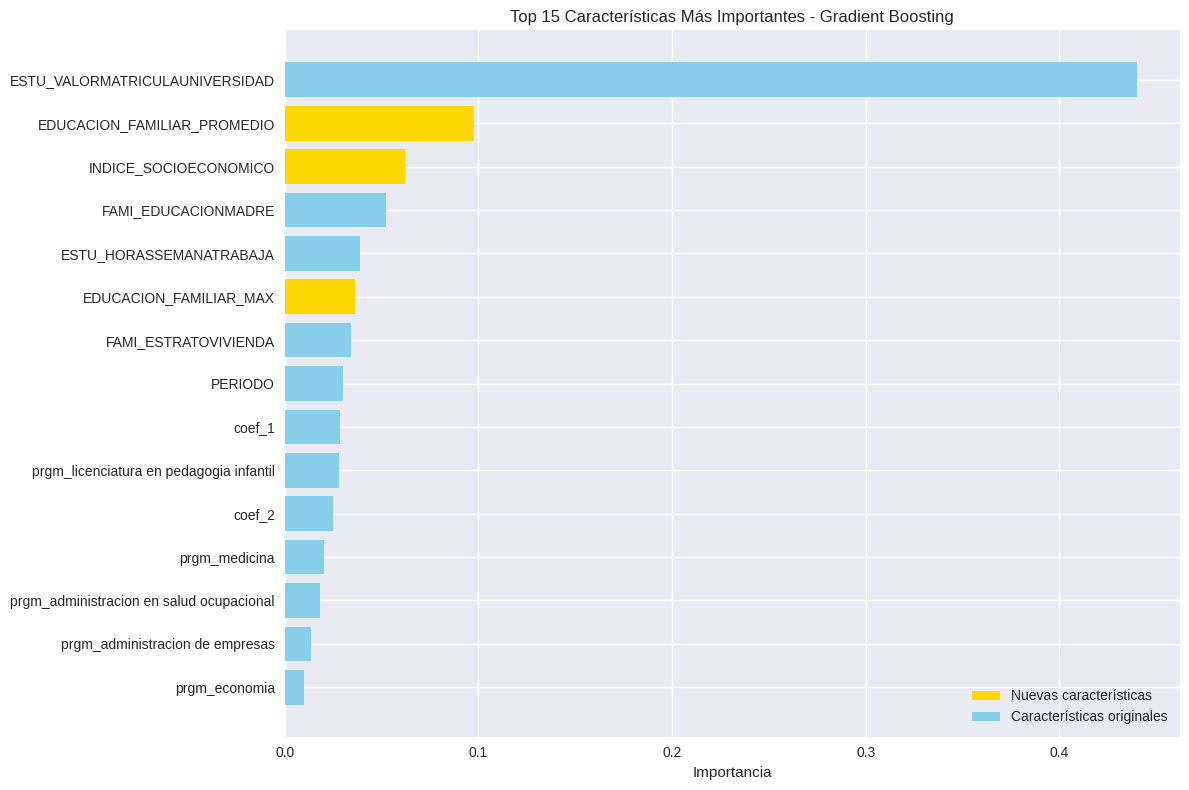

In [17]:
# Análisis de importancia de características
if hasattr(best_model, 'feature_importances_'):
    print(f"Analizando importancia de características para {best_model_name}...")

    # Crear DataFrame con importancias
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print(f"Top 15 características más importantes:")
    top_features = feature_importance.head(15)
    display(top_features)

    # Verificar si las nuevas características están en el top
    new_features_in_top = top_features[top_features['feature'].isin(new_features)]
    if not new_features_in_top.empty:
        print(f"Nuevas características en el Top 15:")
        for _, row in new_features_in_top.iterrows():
            rank = top_features.index[top_features['feature'] == row['feature']].tolist()[0] + 1
            print(f"  #{rank}: {row['feature']} (importancia: {row['importance']:.4f})")
    else:
        print(f"Ninguna nueva característica está en el Top 15")

    # Visualización
    plt.figure(figsize=(12, 8))
    top_15 = feature_importance.head(15)

    # Colorear diferente las nuevas características
    colors = ['gold' if feat in new_features else 'skyblue' for feat in top_15['feature']]

    bars = plt.barh(range(len(top_15)), top_15['importance'], color=colors)
    plt.yticks(range(len(top_15)), top_15['feature'])
    plt.xlabel('Importancia')
    plt.title(f'Top 15 Características Más Importantes - {best_model_name}')
    plt.gca().invert_yaxis()

    # Leyenda
    if any(feat in new_features for feat in top_15['feature']):
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='gold', label='Nuevas características'),
                          Patch(facecolor='skyblue', label='Características originales')]
        plt.legend(handles=legend_elements, loc='lower right')

    plt.tight_layout()
    plt.show()

else:
    print(f"{best_model_name} no proporciona importancia de características")

## Evaluación en conjunto de prueba

In [18]:
# Evaluación final en conjunto de prueba
y_test_pred = best_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Evaluación en conjunto de prueba:")
print(f"Accuracy: {test_accuracy:.4f}")

print(f"Reporte de clasificación (Prueba):")
target_names_test = [label_mapping[i] for i in sorted(label_mapping.keys()) if i in y_test.unique()]
print(classification_report(y_test, y_test_pred, target_names=target_names_test))

# Comparación de rendimiento
print(f"Resumen de rendimiento del modelo {best_model_name}:")
print(f"  - Validación cruzada: {results[best_model_name]['mean']:.4f} (±{results[best_model_name]['std']:.4f})")
print(f"  - Conjunto validación: {val_accuracy:.4f}")
print(f"  - Conjunto prueba: {test_accuracy:.4f}")

# Verificar consistencia
cv_val_diff = abs(results[best_model_name]['mean'] - val_accuracy)
val_test_diff = abs(val_accuracy - test_accuracy)

print(f"Análisis de consistencia:")
print(f"  - Diferencia CV vs Validación: {cv_val_diff:.4f}")
print(f"  - Diferencia Validación vs Prueba: {val_test_diff:.4f}")

if val_test_diff < 0.02:
    print("   Modelo generaliza bien (diferencia < 2%)")
elif val_test_diff < 0.05:
    print("   Modelo generaliza moderadamente (diferencia < 5%)")
else:
    print("   Posible sobreajuste (diferencia >= 5%)")

Evaluación en conjunto de prueba:
Accuracy: 0.4002
Reporte de clasificación (Prueba):
              precision    recall  f1-score   support

        bajo       0.41      0.52      0.46     34597
  medio-bajo       0.32      0.26      0.29     34455
  medio-alto       0.31      0.22      0.25     34324
        alto       0.49      0.60      0.54     35124

    accuracy                           0.40    138500
   macro avg       0.38      0.40      0.39    138500
weighted avg       0.38      0.40      0.39    138500

Resumen de rendimiento del modelo Gradient Boosting:
  - Validación cruzada: 0.4016 (±0.0015)
  - Conjunto validación: 0.4008
  - Conjunto prueba: 0.4002
Análisis de consistencia:
  - Diferencia CV vs Validación: 0.0008
  - Diferencia Validación vs Prueba: 0.0005
   Modelo generaliza bien (diferencia < 2%)


## Entrenamiento del modelo final con todos los datos

In [19]:
# Entrenar modelo final con todos los datos disponibles
print(f"Entrenando modelo final con todos los datos...")

# Preparar todos los datos
X_all_scaled = scaler.fit_transform(X)

# Crear nuevo modelo con los mismos parámetros
final_model = models[best_model_name].__class__(**models[best_model_name].get_params())

# Entrenar con todos los datos
final_model.fit(X_all_scaled, y)

print(f"Modelo final entrenado: {best_model_name}")
print(f"Datos de entrenamiento: {len(X):,} muestras")
print(f"Características totales: {X.shape[1]} (base: {X_base.shape[1]}, nuevas: {len(new_features)})")
print(f"Preprocesamiento: Feature Engineering + StandardScaler")

Entrenando modelo final con todos los datos...
Modelo final entrenado: Gradient Boosting
Datos de entrenamiento: 692,500 muestras
Características totales: 37 (base: 51, nuevas: 5)
Preprocesamiento: Feature Engineering + StandardScaler


## Predicciones para datos de prueba

Advertencia: Faltan 38 columnas en test, agregando con ceros
Columnas numéricas en test: 44/51
  - Columnas socioeconómicas no son numéricas, omitiendo característica
  - Columnas de educación no son numéricas, omitiendo característica
  - Columna de horas de trabajo no es numérica, omitiendo característica
Agregando 10 características faltantes con ceros
Datos de prueba procesados: (296786, 37)
Predicciones generadas: 296,786
Distribución de predicciones:
  - bajo: 235,743 (79.4%)
  - alto: 61,043 (20.6%)


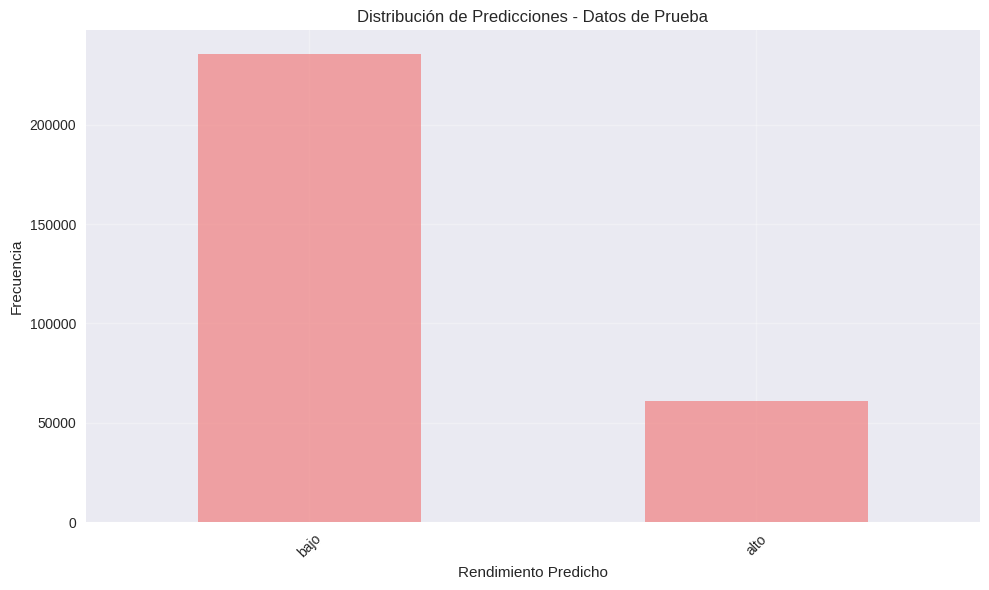

In [21]:
columns_to_drop_test = [col for col in columns_to_drop if col in df_test.columns]
X_test_base = df_test.drop(columns=columns_to_drop_test) if columns_to_drop_test else df_test.copy()

# Seleccionar solo las columnas que existen tanto en train como en test
common_columns = [col for col in X_base.columns if col in X_test_base.columns]
X_test_base = X_test_base[common_columns]

# Agregar columnas faltantes con ceros si es necesario
missing_cols = set(X_base.columns) - set(X_test_base.columns)
if missing_cols:
    print(f"Advertencia: Faltan {len(missing_cols)} columnas en test, agregando con ceros")
    for col in missing_cols:
        X_test_base[col] = 0

# Reordenar columnas para que coincidan con el entrenamiento
X_test_base = X_test_base[X_base.columns]

# Aplicar el mismo feature engineering
X_test_engineered = X_test_base.copy()

numeric_cols_test = X_test_engineered.select_dtypes(include=[np.number]).columns
print(f"Columnas numéricas en test: {len(numeric_cols_test)}/{len(X_test_engineered.columns)}")

socio_cols = ['FAMI_ESTRATOVIVIENDA', 'ESTU_VALORMATRICULAUNIVERSIDAD']
socio_cols_numeric = [col for col in socio_cols if col in numeric_cols_test]
if len(socio_cols_numeric) == 2:
    X_test_engineered['INDICE_SOCIOECONOMICO'] = (
        X_test_engineered[socio_cols_numeric[0]] +
        X_test_engineered[socio_cols_numeric[1]]
    ) / 2
    print("  - Índice socioeconómico creado")
elif len(socio_cols_numeric) > 0:
    print(f"  - Solo {len(socio_cols_numeric)}/2 columnas socioeconómicas son numéricas, omitiendo característica")
else:
    print("  - Columnas socioeconómicas no son numéricas, omitiendo característica")

if available_tech:
    available_tech_numeric = [col for col in available_tech if col in numeric_cols_test]
    if available_tech_numeric:
        X_test_engineered['RECURSOS_TECNOLOGICOS'] = X_test_engineered[available_tech_numeric].sum(axis=1)
        print(f"  - Recursos tecnológicos creados ({len(available_tech_numeric)} variables numéricas)")
    else:
        print("  - Columnas de tecnología no son numéricas, omitiendo característica")

if available_physical:
    available_physical_numeric = [col for col in available_physical if col in numeric_cols_test]
    if available_physical_numeric:
        X_test_engineered['RECURSOS_FISICOS'] = X_test_engineered[available_physical_numeric].sum(axis=1)
        print(f"  - Recursos físicos creados ({len(available_physical_numeric)} variables numéricas)")
    else:
        print("  - Columnas de recursos físicos no son numéricas, omitiendo característica")

if available_edu:
    available_edu_numeric = [col for col in available_edu if col in numeric_cols_test]
    if available_edu_numeric:
        X_test_engineered['EDUCACION_FAMILIAR_MAX'] = X_test_engineered[available_edu_numeric].max(axis=1)
        X_test_engineered['EDUCACION_FAMILIAR_PROMEDIO'] = X_test_engineered[available_edu_numeric].mean(axis=1)
        print(f"  - Educación familiar creada ({len(available_edu_numeric)} variables numéricas)")
    else:
        print("  - Columnas de educación no son numéricas, omitiendo característica")


if 'ESTU_HORASSEMANATRABAJA' in numeric_cols_test:
    X_test_engineered['ESTUDIANTE_TRABAJA'] = (X_test_engineered['ESTU_HORASSEMANATRABAJA'] > 0).astype(int)
    X_test_engineered['TRABAJO_INTENSIVO'] = (X_test_engineered['ESTU_HORASSEMANATRABAJA'] > 20).astype(int)
    print("  - Indicadores de trabajo estudiantil creados")
else:
    print("  - Columna de horas de trabajo no es numérica, omitiendo característica")

if 'PROGRAMA_PRESTIGIOSO' in new_features:
    prestigious_programs_test = [col for col in X_test_engineered.columns if any(keyword in col for keyword in ['INGENIERIA', 'MEDICINA', 'DERECHO'])]
    prestigious_programs_numeric = [col for col in prestigious_programs_test if col in numeric_cols_test]
    if prestigious_programs_numeric:
        X_test_engineered['PROGRAMA_PRESTIGIOSO'] = X_test_engineered[prestigious_programs_numeric].sum(axis=1)
        print(f"  - Programa prestigioso creado ({len(prestigious_programs_numeric)} variables numéricas)")
    else:
        print("  - Columnas de programa no son numéricas, omitiendo característica")


X_test_engineered_numeric = X_test_engineered.select_dtypes(include=[np.number])

# Asegurar que tenemos todas las características que se usaron en entrenamiento
final_missing_cols = set(X.columns) - set(X_test_engineered_numeric.columns)
if final_missing_cols:
    print(f"Agregando {len(final_missing_cols)} características faltantes con ceros")
    for col in final_missing_cols:
        X_test_engineered_numeric[col] = 0

# Reordenar columnas
X_test_engineered_numeric = X_test_engineered_numeric[X.columns]

# Aplicar StandardScaler
X_test_kaggle_scaled = scaler.transform(X_test_engineered_numeric)

print(f"Datos de prueba procesados: {X_test_kaggle_scaled.shape}")

# Generar predicciones con el modelo final
if best_model_name == 'XGBoost':
    test_predictions_raw = final_model.predict(X_test_kaggle_scaled)
    test_predictions = label_encoder.inverse_transform(test_predictions_raw)
else:
    test_predictions = final_model.predict(X_test_kaggle_scaled)

# Convertir a etiquetas de texto
prediction_labels = [label_mapping[pred] for pred in test_predictions]

print(f"Predicciones generadas: {len(test_predictions):,}")

# Distribución de predicciones
pred_counts = pd.Series(prediction_labels).value_counts()
print(f"Distribución de predicciones:")
for label, count in pred_counts.items():
    percentage = (count / len(prediction_labels)) * 100
    print(f"  - {label}: {count:,} ({percentage:.1f}%)")

# Visualización de distribución
plt.figure(figsize=(10, 6))
pred_counts.plot(kind='bar', color='lightcoral', alpha=0.7)
plt.title('Distribución de Predicciones - Datos de Prueba')
plt.xlabel('Rendimiento Predicho')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Creación del archivo de submission

In [24]:
if 'ID' in df_test.columns:
    submission_df = pd.DataFrame({
        'ID': df_test['ID'],
        'RENDIMIENTO_GLOBAL': prediction_labels
    })
elif 'ESTU_CONSECUTIVO' in df_test.columns:
    submission_df = pd.DataFrame({
        'ID': df_test['ESTU_CONSECUTIVO'],
        'RENDIMIENTO_GLOBAL': prediction_labels
    })
else:
    # Generar IDs si no existen
    submission_df = pd.DataFrame({
        'ID': range(len(prediction_labels)),
        'RENDIMIENTO_GLOBAL': prediction_labels
    })

# Guardar archivo
submission_filename = 'submission.csv'
submission_df.to_csv(submission_filename, index=False)

print(f"Archivo de submission guardado: {submission_filename}")
print(f"Registros: {len(submission_df):,}")
print(f"Columnas: {list(submission_df.columns)}")

# Mostrar muestra
print(f"Primeras predicciones:")
display(submission_df.head(10))

# Verificaciones finales
null_count = submission_df.isnull().sum().sum()
unique_values = submission_df['RENDIMIENTO_GLOBAL'].unique()

print(f"Verificaciones finales:")
print(f"  - Valores nulos: {null_count}")
print(f"  - Valores únicos en target: {sorted(unique_values)}")
print(f"  - Formato correcto: {'Sí' if null_count == 0 else 'No'}")

print(f"Archivo listo para Kaggle con formato correcto (ID, etiquetas categóricas)")

Archivo de submission guardado: submission.csv
Registros: 296,786
Columnas: ['ID', 'RENDIMIENTO_GLOBAL']
Primeras predicciones:


,ID,RENDIMIENTO_GLOBAL
0,550236,alto
1,98545,bajo
2,499179,bajo
3,782980,bajo
4,785185,bajo
5,58495,bajo
6,705444,bajo
7,557548,alto
8,519909,bajo
9,832058,alto


Verificaciones finales:
  - Valores nulos: 0
  - Valores únicos en target: ['alto', 'bajo']
  - Formato correcto: Sí
Archivo listo para Kaggle con formato correcto (ID, etiquetas categóricas)


Submit

In [27]:
!kaggle competitions submit -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia -f submission.csv -m "05 modelo con feature engineering y Gradient Boosting"

100% 3.36M/3.36M [00:00<00:00, 7.61MB/s]
Successfully submitted to UDEA/ai4eng 20251 - Pruebas Saber Pro Colombia

In [29]:
!kaggle competitions submissions -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia

fileName           date                        description                                            status                     publicScore  privateScore  
-----------------  --------------------------  -----------------------------------------------------  -------------------------  -----------  ------------  
submission.csv     2025-07-03 21:57:23.173000  05 modelo con feature engineering y Gradient Boosting  SubmissionStatus.COMPLETE  0.27041                    
submission.csv     2025-07-03 18:38:55.810000  Preprocesado 1                                         SubmissionStatus.COMPLETE  0.40097                    
submission_rf.csv  2025-07-03 18:17:28.673000  Preprocesado 1                                         SubmissionStatus.ERROR                                
